In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, HalfwayBounceBackBoundary, FullwayBounceBackBoundary, EquilibriumOutletP, AntiBounceBackOutlet, InterpolatedBounceBackBoundary
from lettuce.flows.cylinder2D import Cylinder2D

import torch
import time
import datetime
import os
import shutil
from pyevtk.hl import imageToVTK

In [9]:
# output?
output_data = False
output_vtk = False   # is overwritten by output_data=False (see below)

# naming:
batch = "cylinder2D_IBB_classTest01"
version = "" #+"_GPD" + str(gridpoints_per_diameter) + "_DpY" + str(domain_width_in_D) + "_Re"+str(re)

### Simulationsparameter - Steuerung
re = 200   # Reynoldszahl
Ma = 0.05     # Machzahl
n_steps = 145492    # Schrittzahl
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

periodic_start = 0.9  # relative start of peak_finding for Cd_mean Measurement to cut of any transients

gridpoints_per_diameter = 1#20 #1  # gp_per_D -> this defines the resolution ( D_LU = GPD+1)
domain_width_in_D = 5#19 #5  # D/Y  -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2*domain_width_in_D  # D/X

# if DpY is even, resulting GPD can't be odd for symmetrical cylinder and channel
# ...if DpY is even, GPD will be corrected to even GPD for symmetrical cylinder
# ...use odd DpY to use odd GPD
gpd_correction=False
if domain_width_in_D % 2 == 0 and gridpoints_per_diameter % 2 != 0:
    gpd_correction = True   # gpd_was_corrected-flag
    gpd_setup = gridpoints_per_diameter   # store old gpd for output
    gridpoints_per_diameter = int(gridpoints_per_diameter/2)*2   # make gpd even
    print("(!) domain_width_in_D is even, gridpoints_per_diameter will be "+str(gridpoints_per_diameter)+". Use odd domain_width_in_D to enable use of odd GPD!")

T_target=200
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/(gridpoints_per_diameter+1))*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round(((gridpoints_per_diameter+1)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round(((gridpoints_per_diameter+1)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")

u_init = 0    # initiales Geschwindigkeitsfeld: # 0: uniform u=0, # 1: uniform u=1, # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # leichte Asymmetrie in Anfangs-Geschwindigkeitsverteilung -> triggert Karman'sche Wirbelstraße für Re>47
lateral_walls = 'periodic'
cylinder = True    # Objekt: True = cylinder, False = no obstascle
bc_type = 'ibb1'    # BounceBackBoundary-Algorithmus: True=Halfway, False=Fullway
vtk_fps=10    # FramesPerSecond (/PU) für vtk-output

#exmpl: Re1000,steps25000,ny1000 braucht 43min
#Bonn: Re200, steps200000,gpd20?, 400x200 braucht 10min
#HBRS: Re200, steps100000, gpd20, 800x400 braucht 25min
#Bonn: Re200, steps175000, gpd35, 1330x665 braucht 62,3min

mlups_2060super = 20
mlups_2080ti = 30   # 40 for GPD30,DpY19,nsteps=150000 (steigend mit der Auflösung)

if output_vtk:
    print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/(gridpoints_per_diameter+1))*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**2*domain_length_in_D*domain_width_in_D
print("No. of gridpoints:", gridpoints)
print("estimated min. runtime on 2060super:", round(n_steps*gridpoints/(1e6*mlups_2060super),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2060super)/60,2),"minutes )")
print("estimated min. runtime on 2080ti:   ", round(n_steps*gridpoints/(1e6*mlups_2080ti),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2080ti)/60,2),"minutes )")

shape_LU: 10 x 5
T with 145492 steps: 2100.0 seconds
n_steps to simulate 1 second: 69.28 steps
n_steps to simulate 200 seconds: 13856.0 steps
No. of gridpoints: 50
estimated min. runtime on 2060super: 0.36 seconds ( 0.01 minutes )
estimated min. runtime on 2080ti:    0.24 seconds ( 0.0 minutes )


In [10]:
### Data_Output (vtk)

#naming -> see above

if output_data:  # toggle output
    # (see above) output_vtk = True    # vtk-Repoter für Animation des Flusses in ParaView: True = vtk-output, False = no vtk-output

    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
    #output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
    #output_path = "/home/mbille3s/02_lbm_simulations"  # cluster HBRS
    dir_name = "/data_" + str(timestamp) + "_" + batch + version
    os.makedirs(output_path+dir_name)
    
    vtk_path = output_path+dir_name+"/vtk/out"    # lokal HBRS UND Bonn # Pfad und Name der vtk-output-Dateien
    print("dir_name: "+dir_name)
    print("output_path: " + vtk_path)
else:
    output_vtk = False

In [11]:
class ObstacleMax:
    """
        (!) refined version of flow/obstacle.py (so far only for 2D obstacles)
        Flow class to simulate the flow around an object (obstacle_mask).
        It consists of one inflow (equilibrium boundary)
        and one outflow (anti-bounce-back-boundary), leading to a flow in positive x direction.

        Parameters (selection)
        ----------
        lateral_walls: True = channel flow with parabolic velocity inlet, False = periodic lateral boundaries and uniform velocity inlet
        hwbb: True = use halfway bounce back boundary, False = use fullway bounce back boundary
        perturb_init: True = slight perturbation in the initial condition to trigger vKarman vortex street in symmetrical systems (for Re>46)
        u_init: initial velocity profile: 0 = uniform u=0, 1 = uniform u=u_char, 2 = parabolic (poiseuille like)

        Attributes (selection)
        ----------
        obstacle_mask : np.array with dtype = np.bool
            Boolean mask to define the obstacle. The shape of this object is the shape of the grid.
            Initially set to zero (no obstacle).

    """

    def __init__(self, reynolds_number, mach_number, lattice, char_length_pu, char_length_lu, char_velocity_pu=1, y_lu=5, x_lu=10, lateral_walls=True, hwbb=True, perturb_init=True, u_init=0):
        self.shape = (int(x_lu), int(y_lu))  # shape of the domain in LU
        self.char_length_pu = char_length_pu  # characteristic length
        self.x_lu = x_lu  # domain length
        self.y_lu = y_lu  # domain width

        self.perturb_init = perturb_init  # toggle: introduce asymmetry in initial solution
        self.u_init = u_init  # toggle: initial solution velocity profile
        self.lateral_walls = lateral_walls  # toggle: lateral walls or lateral periodic boundary
        self.hwbb = hwbb  # toggle: bounce back algorithm: halfway or fullway

        self.units = UnitConversion(
            lattice,
            reynolds_number=reynolds_number,
            mach_number=mach_number,
            characteristic_length_lu=char_length_lu,
            characteristic_length_pu=char_length_pu,
            characteristic_velocity_pu=char_velocity_pu  ### reminder: u_char_lu = Ma * cs_lu = Ma * 1/sqrt(3)
        )

        self.solid_mask = np.zeros(shape=self.shape, dtype=bool)  # marks all solid nodes (obstacle, walls, ...)
        self.in_mask = np.zeros(self.grid[0].shape, dtype=bool)  # marks all inlet nodes
       # self.in_mask[0, 1:-1] = True  # inlet on the left
        self.wall_mask = np.zeros_like(self.solid_mask)  # marks lateral walls
        self._obstacle_mask = np.zeros_like(self.solid_mask)  # marks all obstacle nodes (for fluid-solid-force_calc.)

        if self.lateral_walls:
            self.wall_mask[:, [0, -1]] = True
            self.solid_mask[np.where(self.wall_mask)] = 1
            self.in_mask[0, 1:-1] = True  # inlet on the left, except for top and bottom wall (y=0, y=y_max)
        else: # if lateral_wals == 'periodic'
            self.in_mask[0, :] = True  # inlet on the left (x=0)

        # generate parabolic velocity profile for inlet BC if lateral_walls=True (== channel-flow)
        self.u_inlet = self.units.characteristic_velocity_pu * self._unit_vector()
        if self.lateral_walls:
            ## parabolic velocity profile, zeroing on the edges
            ## How to parabola:
            ## 1.parabola in factoriezed form (GER: "Nullstellenform"): y = (x-x1)*(x-x2)
            ## 2.parabola with a maximum and zero at x1=0 und x2=x0: y=-x*(x-x0)
            ## 3.scale parabola, to make y_s(x_s)=1 the maximum: y=-x*(x-x0)*(1/(x0/2)²)
            ## (4. optional) scale amplitude with 1.5 to have a mean velocity of 1, also making the integral of a homogeneous velocity profile with u=1 and the parabolic profile being equal
            ny = self.shape[1]  # number of gridpoints in y direction
            ux_temp = np.zeros((1, ny))  # variable for x-velocities on inlet boundary
            y_coordinates = np.linspace(0, ny, ny)  # linspace() creates n points between 0 and ny, including 0 and ny:
                # top and bottom velocity values will be zero to agree with wall-boundary-condition
            ux_temp[:, 1:-1] = - np.array(self.u_inlet).max() * y_coordinates[1:-1] * (y_coordinates[1:-1] - ny) * 1 / (ny / 2) ** 2  # parabolic velocity profile
            # scale with 1.5 to achieve a mean velocity of u_char!
            # in 2D u1 needs Dimension 1 x ny (!)
            uy_temp = np.zeros_like(ux_temp)  # y-velocities = 0
            self.u_inlet = np.stack([ux_temp, uy_temp], axis=0)  # stack/pack u-field

    @property
    def obstacle_mask(self):
        return self._obstacle_mask

    @obstacle_mask.setter
    def obstacle_mask(self, m):
        assert isinstance(m, np.ndarray) and m.shape == self.shape
        self._obstacle_mask = m.astype(bool)
        self.solid_mask[np.where(self._obstacle_mask)] = 1  # (!) this line is not doing what it should! solid_mask is now defined in the initial solution (see below)!

    def initial_solution(self, x):
        p = np.zeros_like(x[0], dtype=float)[None, ...]
        u_max_lu = self.units.characteristic_velocity_lu * self._unit_vector()
        u_max_lu = append_axes(u_max_lu, self.units.lattice.D)
        self.solid_mask[np.where(self.obstacle_mask)] = 1  # This line is needed, because the obstacle_mask.setter does not define the solid_mask properly (see above)
        ### initial velocity field: "u_init"-parameter
        # 0: uniform u=0
        # 1: uniform u=1
        # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
        u = (1 - self.solid_mask) * u_max_lu
        if self.u_init == 1:
            # initiale velocity u=1 on every fluid node
            u = (1 - self.solid_mask) * u_max_lu
        elif self.u_init == 2:  # parabolic along y, uniform along x (similar to poiseuille-flow)
            ny = self.shape[1]  # number of gridpoints in y direction
            ux_factor = np.zeros(ny)  # vector for one column (u(x=0))
            # multiply parabolic profile with every column of the velocity field:
            y_coordinates = np.linspace(0, ny, ny)
            ux_factor[1:-1] = - y_coordinates[1:-1] * (y_coordinates[1:-1] - ny) * 1 / (ny / 2) ** 2
            u = np.einsum('k,ijk->ijk', ux_factor, u)
        else:
            u = u*0  # uniform u=0

        ### perturb initial velocity field-symmetry to trigger 'von Karman' vortex street
        # perturb_init = True/False
        if self.perturb_init:
            # overlays a sine-wave on the second column of nodes
            ny = x[1].shape[1]
            if u.max() < 0.5 * self.units.characteristic_velocity_lu:
                # add perturbation for small velocities
                u[0][1] += np.sin(np.linspace(0, ny, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_lu * 1.0
            else:
                # multiply scaled down perturbation
                u[0][1] *= 1 + np.sin(np.linspace(0, ny, ny) / ny * 2 * np.pi) * 0.3
        return p, u

    @property
    def grid(self):
        xyz = tuple(self.units.convert_length_to_pu(np.linspace(0,n,n)) for n in self.shape)  # tuple of lists of x,y,(z)-values/indices
        return np.meshgrid(*xyz, indexing='ij')  # meshgrid of x-, y- (und z-)values/indices

    @property
    def boundaries(self):
        # inlet ("left side", x[0],y[1:-1])
        inlet_boundary = EquilibriumBoundaryPU(
                                            self.in_mask,
                                            self.units.lattice, self.units,
                                            #self.units.characteristic_velocity_pu * self._unit_vector())
                                            self.u_inlet) # works with a 1 x D vector or an ny x D vector thanks to einsum-magic in EquilibriumBoundaryPU
        # lateral walls ("top and bottom walls", x[:], y[0,-1])
        lateral_boundary = None
        if self.lateral_walls:
            if self.hwbb:  # use halfway bounce back
                lateral_boundary = HalfwayBounceBackBoundary(self.wall_mask, self.units.lattice)
            else:  # else use fullway bounce back
                lateral_boundary = FullwayBounceBackBoundary(self.wall_mask, self.units.lattice)
        # outlet ("right side", x[-1],y[:])
        outlet_boundary = EquilibriumOutletP(self.units.lattice, [1, 0])  # outlet in positive x-direction
        # obstacle (for example: obstacle "cylinder" with radius centered at position x_pos, y_pos) -> to be set via obstacle_mask.setter
        obstacle_boundary = None
        # (!) the obstacle_boundary should alway be the last boundary in the list of boundaries to correctly calculate forces on the obstacle
        # if self.hwbb:
        #     obstacle_boundary = HalfwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)
        # else:
        #     obstacle_boundary = FullwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)
        obstacle_boundary = InterpolatedBounceBackBoundary(self.obstacle_mask, self.units.lattice, x_center=0.5 * gridpoints_per_diameter * domain_width_in_D - 0.5, y_center=0.5 * gridpoints_per_diameter * domain_width_in_D - 0.5, radius=0.5 * gridpoints_per_diameter)
        if lateral_boundary is None:  # if lateral boundary is periodic...don't return a boundary-object
            return [
                inlet_boundary,
                outlet_boundary,
                obstacle_boundary
                ]
        else:
            return [
                inlet_boundary,
                outlet_boundary,
                lateral_boundary,
                obstacle_boundary
                ]

    def _unit_vector(self, i=0):
        return np.eye(self.units.lattice.D)[i]


In [12]:
### Simulationssetup

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
    # stencil, device, dtype

# flow = ObstacleMax(reynolds_number=re, mach_number=Ma,
flow = Cylinder2D(reynolds_number=re, mach_number=Ma,
                   lattice=lattice,
                   char_length_pu=setup_diameter, 
                   char_length_lu=gridpoints_per_diameter+1, 
                   char_velocity_pu=flow_velocity, 
                   y_lu=domain_width_in_D*gridpoints_per_diameter, 
                   x_lu=domain_length_in_D*gridpoints_per_diameter, 
                   lateral_walls=lateral_walls,
#                   hwbb=halfway,
                   bc_type=bc_type,
                   perturb_init=perturb_init, 
                   u_init=u_init,
                   radius=gridpoints_per_diameter/2
                  )

# define a Cylinder-Obstacle (in LU, 1-based!)
radius_LU = 0.5 * gridpoints_per_diameter
y_pos_LU = 0.5 * gridpoints_per_diameter * domain_width_in_D + 0.5
x_pos_LU = y_pos_LU
print("1-based: x0,y0, radius:",x_pos_LU,"",y_pos_LU,"",radius_LU)

xyz = tuple(np.linspace(1,n,n) for n in flow.shape)  # Tupel aus Listen indizes (1-n (nicht 0-based!))
xLU, yLU = np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Indizes

condition = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU
flow.obstacle_mask[np.where(condition)] = 1

### Simulations-Objekt (Simulator)
tau = flow.units.relaxation_parameter_lu
sim = lt.Simulation(flow, lattice, 
                     lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau), 
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, KollisionsOperator-Objekt(Parameter), Streaming-Objekt

### Reporter

# VTK Reporter -> Visualisierung
if output_vtk:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)
    # export obstacle
    mask_dict = dict()
    mask_dict["mask"] = flow.obstacle_mask[...,None].astype(int)
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_point",
        pointData=mask_dict,
    )
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_cell",
        cellData=mask_dict,
    )

# Observable reporter: drag coefficient
DragObservable = lt.DragCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter)  # erstelle Observable // ! area A=2*r is in PU
Dragreport = lt.ObservableReporter(DragObservable, out=None)  # erstelle Reporter für Observable
sim.reporters.append(Dragreport)  # hänge Reporter in Simulator ein
    
# Observable reporter: lift coefficient
LiftObservable = lt.LiftCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter)
Liftreport = lt.ObservableReporter(LiftObservable, out=None)
sim.reporters.append(Liftreport)
    
# MassObservable = lt.Mass(lattice,flow)
# MassReporter = lt.ObservableReporter(MassObservable, out=None)
# sim.reporters.append(MassReporter)

1-based: x0,y0, radius: 3.0  3.0  0.5
x_center =  2.0 ,y_center =  2.0 , radius =  0.5
xb,yb,i,d1,d2 xf, yf, cx, cy: 2 2 1 1.5 0.5 3 2 -1 0
xb,yb,i,d1,d2 xf, yf, cx, cy: 2 2 2 1.5 0.5 2 3 0 -1
xb,yb,i,d1,d2 xf, yf, cx, cy: 2 2 3 1.5 0.5 1 2 1 0
xb,yb,i,d1,d2 xf, yf, cx, cy: 2 2 4 1.5 0.5 2 1 0 1
xb,yb,i,d1,d2 xf, yf, cx, cy: 2 2 5 1.3535533905932737 0.6464466094067263 3 3 -1 -1
xb,yb,i,d1,d2 xf, yf, cx, cy: 2 2 6 1.3535533905932737 0.6464466094067263 1 3 1 -1
xb,yb,i,d1,d2 xf, yf, cx, cy: 2 2 7 1.3535533905932737 0.6464466094067263 1 1 1 1
xb,yb,i,d1,d2 xf, yf, cx, cy: 2 2 8 1.3535533905932737 0.6464466094067263 3 1 -1 1
IBB initialization took 0.0006439685821533203seconds


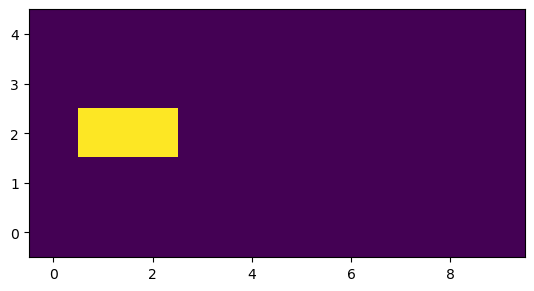

In [6]:
plt.figure()
#plt.imshow(lattice.convert_to_numpy(torch.logical_xor(sim._boundaries[-1].mask, sim._boundaries[-1].f_mask[1])[190-20:190+20,190-20:190+20])[:,:].T, origin="lower")
plt.imshow(lattice.convert_to_numpy(torch.logical_xor(sim._boundaries[-1].mask, sim._boundaries[-1].f_mask[1]))[:,:].T, origin="lower")
ax = plt.gca()
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
#ax.set_xticks(np.arange(-.5, xmax, 1), minor=True)
#ax.set_yticks(np.arange(-.5, ymax, 1), minor=True)
#ax.grid(which="minor", color="w",linestyle='-', linewidth=2)

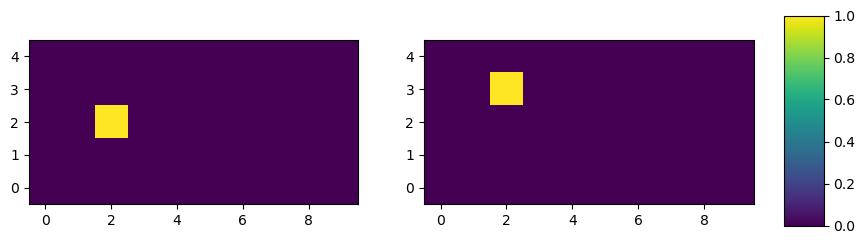

In [13]:
from matplotlib import pyplot as plt
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].f_mask[1,190-20:190+20,190-20:190+20]), origin="lower")
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[7,190-20:190+20,190-20:190+20]), origin="lower")
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[3].T), origin="lower")
print(sim._boundaries[-1])

fig, axes = plt.subplots(1,2, figsize=(10,3))
fig.subplots_adjust(right=0.85)
# im2 = plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[2,190-20:190+20,190-20:190+20].T), origin="lower")
# axes[0].imshow(lattice.convert_to_numpy(sim._boundaries[-1].mask[190-20:190+20,190-20:190+20].T), origin="lower")
im2 = plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].f_mask[4].T), origin="lower")
axes[0].imshow(lattice.convert_to_numpy(sim._boundaries[-1].mask.T), origin="lower")
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

In [8]:
### Einfache Simulation

t_start=time.time()

mlups = sim.step(n_steps) #Simulation mit Schrittzahl n_steps

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")
print("collision avg. time:", sim.time_avg["time_collision"], "seconds")
print("streaming avg. time:", sim.time_avg["time_streaming"], "seconds")
print("boundary avg. time:", sim.time_avg["time_boundary"], "seconds")
print("reporter avg. time:", sim.time_avg["time_reporter"], "seconds")

MLUPS: 19.785742695170416
PU-Time:  199.99963182127868  seconds
number of steps: 145492
runtime:  2123.6611092090607 seconds ( 35.39 minutes )
collision avg. time: 0.00036804325778120445 seconds
streaming avg. time: 0.0002740530257556659 seconds
boundary avg. time: 0.012965312589651378 seconds
reporter avg. time: 0.0009879062969037314 seconds


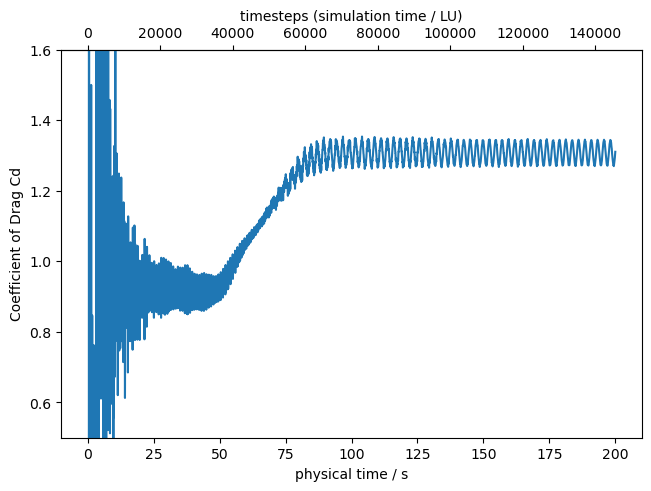

In [10]:
### plot DRAG COEFFICIENT

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])
#ax.set_ylim([1.54,1.545])
#ax.set_xlim([500,600])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")
plt.show()

simple mean:      1.3066512299768003
peak_finder mean: 1.307301494128304
start time of 'mean'-ing: 179.99856892435236


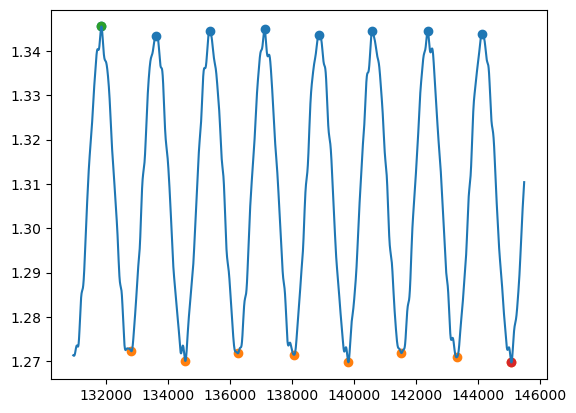

In [11]:
### calculate MEAN DRAG COEFFICIENT in periodic reagion:
try:
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]

    peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
    peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))
    # find peaks funktioniert hier nicht korrekt, wenn der Drag immernoch ansteigend ist...

    if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
        peak_number = peaks_max[0].shape[0]
    else:
        peak_number = peaks_min[0].shape[0]

    if peaks_min[0][0] < peaks_max[0][0]:
        first_peak = peaks_min[0][0]
        last_peak = peaks_max[0][peak_number-1]
    else:
        first_peak = peaks_max[0][0]
        last_peak = peaks_min[0][peak_number-1]

    drag_mean = values[first_peak:last_peak].mean()
    drag_mean_simple = values.mean()

    print("simple mean:     ",drag_mean_simple)
    print("peak_finder mean:",drag_mean)
    print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1])
    ## plotting peaks from peak_finder:
    drag_stepsLU = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,0]
    peak_max_y = values[peaks_max[0]]
    peak_max_x = drag_stepsLU[peaks_max[0]]
    peak_min_y = values[peaks_min[0]]
    peak_min_x = drag_stepsLU[peaks_min[0]]

    plt.plot(drag_stepsLU, values)
    plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number])
    plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number])
    plt.scatter(drag_stepsLU[first_peak],values[first_peak])
    plt.scatter(drag_stepsLU[last_peak],values[last_peak])
    if output_data:
        plt.savefig(output_path+dir_name+"/drag_coefficient_peakfinder.png")
    peakfinder=True
except:
    print("peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)")
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]
    drag_mean_simple = values.mean()
    peakfinder=False
    print("Cd, simple mean:",drag_mean_simple)

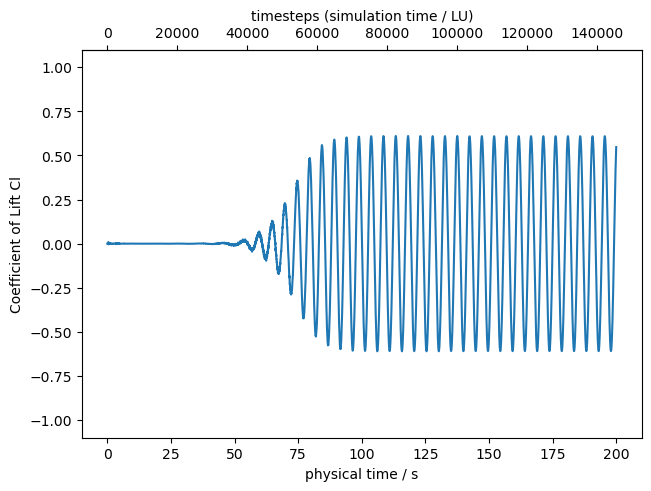

Cl_peaks: 
min -0.6101486949068793 
max 0.6103129225891917


In [13]:
### plot LIFT COEFFICIENT

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1.1,1.1])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

Cl_min = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].min()
Cl_max = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].max()
#Cl_min_gpdC = Cl_min/(1+1/gridpoints_per_diameter)
#Cl_max_gpdC = Cl_max/(1+1/gridpoints_per_diameter)

print("Cl_peaks: \nmin", Cl_min,"\nmax", Cl_max)
#print("Cl_peaks (gpd-corrected): \nmin", Cl_min_gpdC,"\nmax", Cl_max_gpdC)

Frequency Peak: 0.20499896837879528 +- 0.004999974838507202 Hz


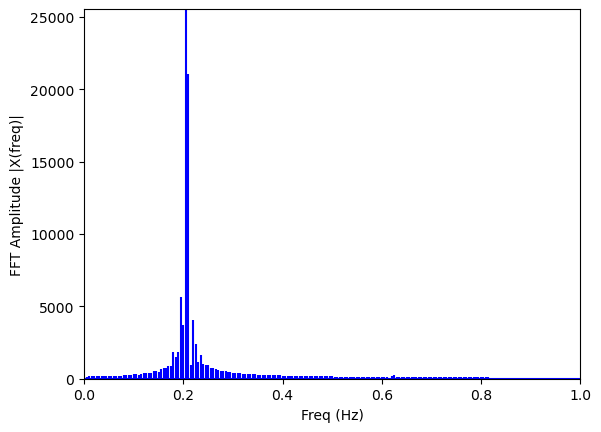

In [14]:
### STROUHAL NUMBER
# prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

try:
    X = np.fft.fft(lift_coefficient[:,2])   # fft result (amplitudes)
    N = len(X)  # number of freqs
    n = np.arange(N)   # freq index
    T = N*flow.units.convert_time_to_pu(1)   # total time measured (T_PU)
    freq = n/T   # frequencies (x-axis of spectrum)

    plt.figure
    plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")   # plot spectrum |X|(f)
    plt.xlabel("Freq (Hz)")
    plt.ylabel("FFT Amplitude |X(freq)|")
    plt.xlim(0,1)
    #print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
    plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum

    if output_data:
        plt.savefig(output_path+dir_name+"/fft_Cl.png")

    freq_res = freq[1]-freq[0]   # frequency-resolution
    X_abs = np.abs(X[:int(X.shape[0]*0.4)])   # get |X| Amplitude for left half of full spectrum
    freq_peak = freq[np.argmax(X_abs)]    # find frequency with highest amplitude
    print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
    # f = Strouhal for St=f*D/U and D=U=1 in PU
except:
    print("Strouhal-calculation failed, check simulation data")
    freq_res=0
    freq_peak=0

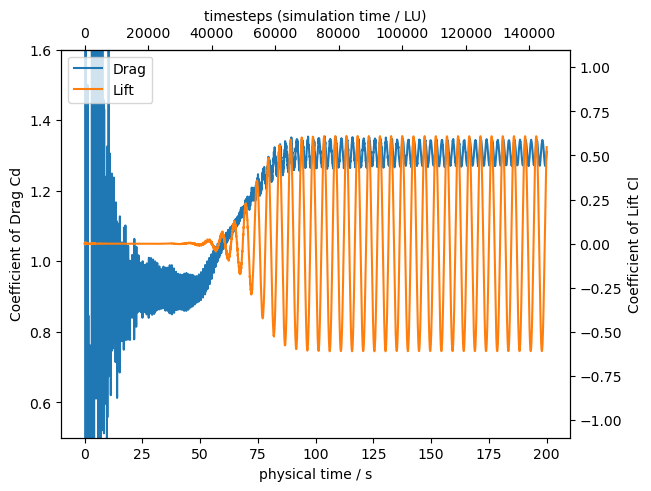

In [15]:
### plot Drag coefficient AND Lift Coefficient

#drag_coefficient = np.array(Dragreport.out)
#lift_coefficient = np.array(Liftreport.out)

fig, ax = plt.subplots(layout="constrained")
drag_ax = ax.plot(drag_coefficient[:,1],drag_coefficient[:,2], color="tab:blue", label="Drag")
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")

ax2 = ax.twinx()
lift_ax = ax2.plot(lift_coefficient[:,1],lift_coefficient[:,2], color="tab:orange", label="Lift")
ax2.set_ylabel("Coefficient of Lift Cl")
ax2.set_ylim([-1.1,1.1])


fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

if output_data:
    plt.savefig(output_path+dir_name+"/dragAndLift_coefficient.png")

plt.show()

In [16]:
### plotte Dichte (mean, max, min) im Fluid-Bereich

# plt.figure
# plt.plot(np.arange(len(DragObservable.rho_max_list)),DragObservable.rho_max_list)
# plt.plot(np.arange(len(DragObservable.rho_min_list)),DragObservable.rho_min_list)
# plt.plot(np.arange(len(DragObservable.rho_mean_list)),DragObservable.rho_mean_list)
# plt.legend(labels=["rho_max", "rho_min", "rho_mean"])
# plt.ylim([0.99,1.01])
# if output_data:
#     plt.savefig(output_path+dir_name+"/density.png")

In [17]:
# save notebook to simulation_output
if output_data:
    shutil.copy(str(os.getcwd())+"/cylinder2D_development.ipynb",output_path+dir_name+"/script.ipynb")
else:
    print("output_data-toggle is FALSE")


In [18]:
# output data
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nMa = "+str(Ma))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nsetup_diameter (D_PU) = "+str(setup_diameter))
    output_file.write("\nflow_velocity (U_PU) = "+str(flow_velocity))
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\ndomain_width_in_D (D/Y) = "+str(domain_width_in_D))
    output_file.write("\ndomain_length_in_D (D/X) = "+str(domain_length_in_D))
    output_file.write("\n")
    output_file.write("\nu_init = "+str(u_init))
    output_file.write("\nperturb_init = "+str(perturb_init))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\nbc_type = "+str(bc_type))
    output_file.write("\nvtk_fps = "+str(vtk_fps))
    output_file.write("\noutput_vtk = "+str(output_vtk))
    output_file.write("\n")
    output_file.write("\nshape_LU: "+ str(flow.shape[0]) + " x " + str(flow.shape[1]))
    output_file.write("\ntotal No. of gridpoints: "+ str(gridpoints))
    output_file.write("\n")
    output_file.write("output_dir: "+str(output_path+dir_name))
    output_file.write("\n")
    output_file.write("\n###################\n\ncylinder:")
    output_file.write("\nradius_LU = "+str(radius_LU))
    output_file.write("\nx_pos_LU = "+str(x_pos_LU))
    output_file.write("\ny_pos_LU = "+str(y_pos_LU))
    output_file.write("\ntau = "+str(tau))
    output_file.write("\n")
    output_file.write("\n###################\n\nSTATS:")
    output_file.write("\nT_PU = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\n###################\n\nOBSERVABLES:")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(Cl_min))
    output_file.write("\nCl_max = "+str(Cl_max))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nf +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.close()


In [19]:
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables_copyable.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters: Re, Ma, n_steps, setup_diameter, flow_velocity, GPD, DpY, DpX, u_init, perturb_init, bb_wall, vtk_fps, output_vtk, shape_LU, gridpoints, output_dir, radius_LU, x_pos_LU, y_pos_LU, tau, T_PU, runtime, MLUPS")
    output_file.write("\n"+str(re))
    output_file.write("\n"+str(Ma))
    output_file.write("\n"+str(n_steps))
    output_file.write("\n"+str(setup_diameter))
    output_file.write("\n"+str(flow_velocity))
    output_file.write("\n"+str(gridpoints_per_diameter))
    output_file.write("\n"+str(domain_width_in_D))
    output_file.write("\n"+str(domain_length_in_D))
    output_file.write("\n"+str(u_init))
    output_file.write("\n"+str(perturb_init))
    output_file.write("\n"+str(lateral_walls))
    output_file.write("\n"+str(lateral_walls))
    output_file.write("\n"+str(vtk_fps))
    output_file.write("\n"+str(output_vtk))
    output_file.write("\n")
    output_file.write("\n"+ str(flow.shape[0]) + " x " + str(flow.shape[1]))
    output_file.write("\n"+ str(gridpoints))
    output_file.write("\n")
    output_file.write(""+str(output_path+dir_name))
    output_file.write("\n")
    output_file.write("\n"+str(radius_LU))
    output_file.write("\n"+str(x_pos_LU))
    output_file.write("\n"+str(y_pos_LU))
    output_file.write("\n"+str(tau))
    output_file.write("\n")
    output_file.write("\n"+str(flow.units.convert_time_to_pu(n_steps)))
    output_file.write("\n"+str(runtime))
    output_file.write("\n"+str(mlups))
    output_file.write("\n")
    output_file.write("\n###################\n\nOBSERVABLES: CdmeanSimple, (Cdpeakfinder), Cdmin,Cdmax,Clmin,Clmax,St,df")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\n"+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\n"+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\n"+str(Cl_min))
    output_file.write("\n"+str(Cl_max))
    output_file.write("\n")
    output_file.write("\n"+str(freq_peak))
    output_file.write("\n"+str(freq_res))
    output_file.close()

In [20]:
torch.cuda.memory_allocated(device="cuda:0")/1024/1024

66.78515625

In [21]:
### Analysis of GPU memory usage (tensors)

if output_data:
### cudas own memory summary
    print(torch.cuda.memory_summary(device="cuda:0"))
    ### CUDA-VRAM-summary:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_memory_summary.txt", "a")
    output_file.write("DATA for "+timestamp+"\n\n")
    output_file.write(torch.cuda.memory_summary(device="cuda:0"))
    output_file.close()

### list present torch tensors:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt", "a")
    total_bytes = 0
    import gc
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
                output_file.write("\n"+str(obj.size())+", "+str(obj.nelement()*obj.element_size()))
                total_bytes = total_bytes+obj.nelement()*obj.element_size()
        except:
            pass
    output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

### count occurence of tensors in list of tensors:
    from collections import Counter
    my_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt","r")
    data=my_file.read()
    my_file.close()
    data_into_list=data.split("\n")
    c = Counter(data_into_list)
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_counted_tensors.txt", "a")
    for k,v in c.items():
        output_file.write("type,size,bytes: {}, number: {}\n".format(k,v) )
    output_file.write("\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   68388 KB |  173326 KB |  142847 GB |  142847 GB |
|       from large pool |   67535 KB |  172474 KB |  142643 GB |  142643 GB |
|       from small pool |     852 KB |    1420 KB |     204 GB |     204 GB |
|---------------------------------------------------------------------------|
| Active memory         |   68388 KB |  173326 KB |  142847 GB |  142847 GB |
|       from large pool |   67535 KB |  172474 KB |  142643 GB |

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [20]:
lattice.convert_to_numpy(lattice.u(sim.f)).shape

(2, 760, 380)

In [21]:
lattice.convert_to_numpy(lattice.u(sim.f))

array([[[ 2.88675135e-02,  2.88675135e-02,  2.88675135e-02, ...,
          2.88675135e-02,  2.88675135e-02,  2.88675135e-02],
        [ 1.81370051e-02,  1.81370138e-02,  1.81370389e-02, ...,
          1.81370700e-02,  1.81370951e-02,  1.81371038e-02],
        [ 1.81385319e-02,  1.81384089e-02,  1.81383493e-02, ...,
          1.81388747e-02,  1.81388151e-02,  1.81386920e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-3.46944695e-18, -3.46944695e-18, -3.46944695e-18, ...,
         -3.46944695e-18, -3.46944695e-18, -3.46944695e-18],
        [ 1.38069712e-07,  2.15265543e-07,  2.11690777e-07, ...,
          2.11533662e-07,  2.15124751e

In [22]:
flow.u_inlet

array([1., 0.])

In [23]:
flow.boundaries